# Using LSTM Model to Predict Tesla Stock Price

In this notebook we will be building and training LSTM to predict Tesla stock. We will use PyTorch.

## 1. Libraries and settings

In [1]:
import numpy as np
import pandas as pd
from pylab import mpl, plt

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
% matplotlib inline

import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

## 2. Load data

In [2]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv("./data/tsla.us.txt".format(symbol),
                              index_col='Date',
                              parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

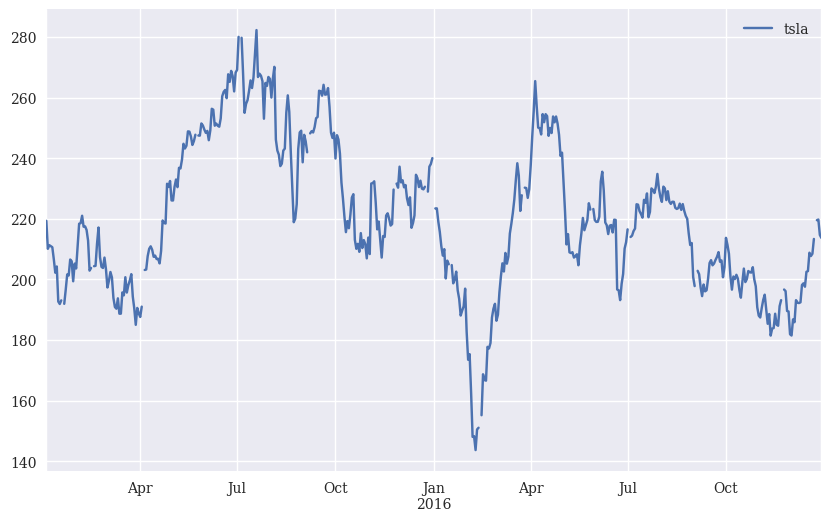

In [3]:
dates = pd.date_range('2015-01-02', '2016-12-31', freq='B')
symbols = ['tsla']
df = stocks_data(symbols, dates)
df.fillna(method='pad')
df.plot(figsize=(10, 6), subplots=True);

In [4]:
df.head()

,tsla
2015-01-02,219.31
2015-01-05,210.09
2015-01-06,211.28
2015-01-07,210.95
2015-01-08,210.62


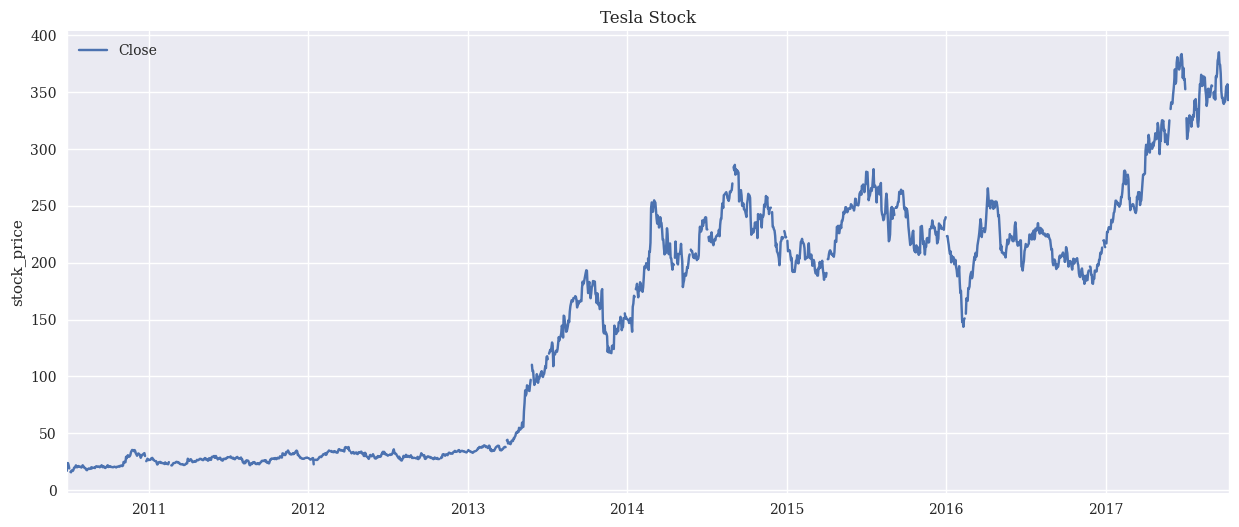

In [7]:
dates = pd.date_range('2010-06-28', '2017-10-11', freq='B')
df1 = pd.DataFrame(index=dates)
df_tsla = pd.read_csv("./data/tsla.us.txt", parse_dates=True, index_col=0)
df_tsla = df1.join(df_tsla)
df_tsla[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("Tesla Stock")
plt.show()

In [9]:
df_tsla = df_tsla[['Close']]
df_tsla.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1903 entries, 2010-06-28 to 2017-10-11
Freq: B
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1836 non-null   float64
dtypes: float64(1)
memory usage: 94.3 KB


In [10]:
df_tsla = df_tsla.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
df_tsla['Close'] = scaler.fit_transform(df_tsla['Close'].values.reshape(-1, 1))

In [11]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values  # convert to numpy array
    data = []

    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]


look_back = 60  # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_tsla, look_back)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (1474, 59, 1)
y_train.shape =  (1474, 1)
x_test.shape =  (369, 59, 1)
y_test.shape =  (369, 1)


In [12]:
x_train

array([[[-0.99349946],
        [-0.95617551],
        [-0.95650054],
        ...,
        [-0.97118093],
        [-0.96652221],
        [-0.97215601]],

       [[-0.95617551],
        [-0.95650054],
        [-0.96663055],
        ...,
        [-0.96652221],
        [-0.97215601],
        [-0.97600217]],

       [[-0.95650054],
        [-0.96663055],
        [-0.9815818 ],
        ...,
        [-0.97215601],
        [-0.97600217],
        [-0.97156013]],

       ...,

       [[-0.24501625],
        [-0.17183099],
        [-0.18217768],
        ...,
        [ 0.12004334],
        [ 0.06029252],
        [ 0.07871073]],

       [[-0.17183099],
        [-0.18217768],
        [-0.18320693],
        ...,
        [ 0.06029252],
        [ 0.07871073],
        [ 0.04615385]],

       [[-0.18217768],
        [-0.18320693],
        [-0.1227519 ],
        ...,
        [ 0.07871073],
        [ 0.04615385],
        [ 0.04490791]]])

In [13]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [14]:
y_train.size(), x_train.size()

(torch.Size([1474, 1]), torch.Size([1474, 59, 1]))

## 3. Build the structure of model

In [15]:
# Build model
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out


model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [16]:
# Train model
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim = look_back - 1

for t in range(num_epochs):
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t != 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.020898152142763138
Epoch  20 MSE:  0.016849013045430183
Epoch  30 MSE:  0.00798929575830698
Epoch  40 MSE:  0.0043462770991027355
Epoch  50 MSE:  0.0029269009828567505
Epoch  60 MSE:  0.0020652569364756346
Epoch  70 MSE:  0.0018127512885257602
Epoch  80 MSE:  0.0016057167667895555
Epoch  90 MSE:  0.001486914581619203


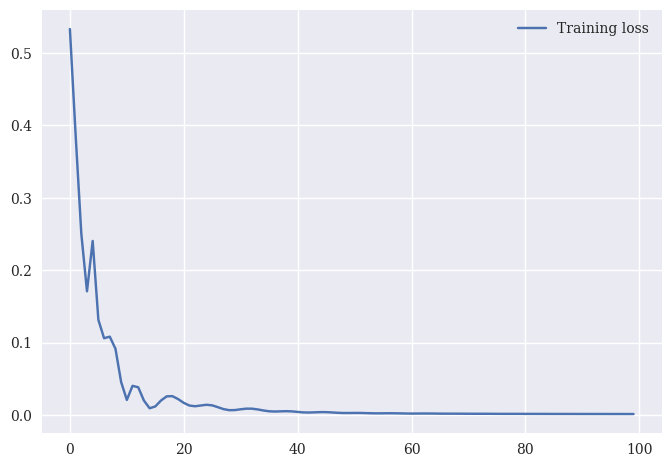

In [17]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [18]:
np.shape(y_train_pred)

torch.Size([1474, 1])

In [19]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:, 0], y_test_pred[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 6.98 RMSE
Test Score: 15.99 RMSE


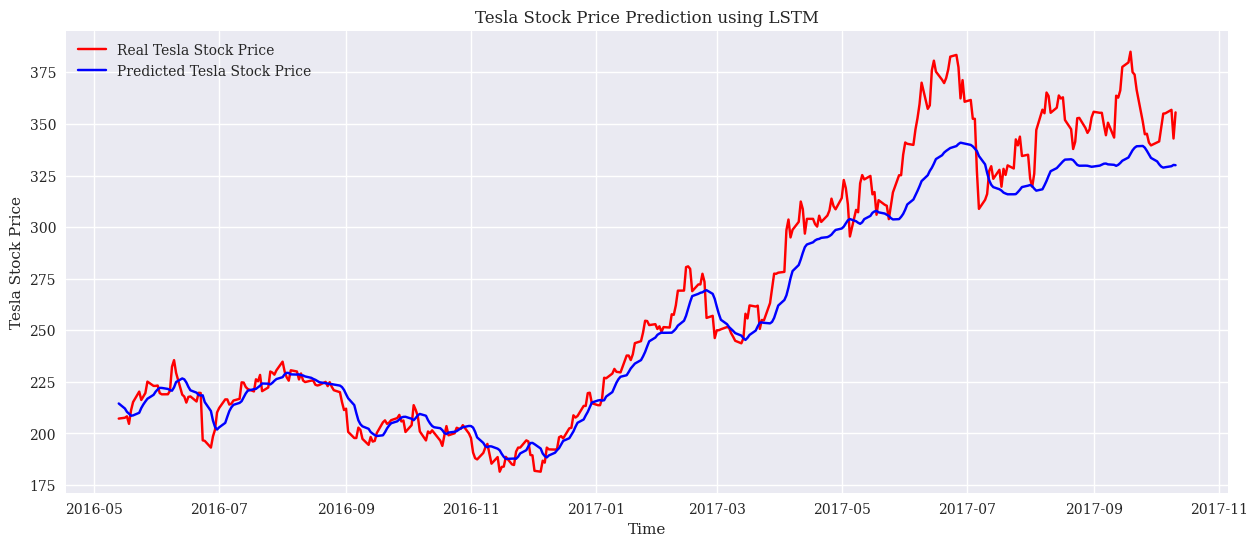

In [21]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df_tsla[len(df_tsla) - len(y_test):].index, y_test, color='red', label='Real Tesla Stock Price')
axes.plot(df_tsla[len(df_tsla) - len(y_test):].index, y_test_pred, color='blue', label='Predicted Tesla Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Tesla Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.savefig('tsla_pred.png')
plt.show()